In [18]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
from scipy.interpolate import griddata
from tqdm import tqdm

# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')

import csv
from fio import readin
from visualization import contour_generator
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')

## Summary:
This notebook detects breaking fronts, maps them to velocity field, and computes breaker statistics.
## <a class="anchor" id="0">Table of content: </a> 

#### [1. Define the case class and helper functions](#1)
#### [2. Compile stats](#2)
#### [3. Relate to wind condition](#3)

### <a class="anchor" id="1">Define class and functions</a>

#### Some help functions

In [3]:
""" The detection function """
import matplotlib.pyplot as plt
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def detect_slope(grad, threshold):
    return (np.logical_not(grad > threshold))
    
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

In [4]:
""" Energy plotting functions """
from matplotlib.legend_handler import HandlerTuple
def read(path,name):
    energy,exists = readin(path+name, table_delimiter = ' ', table_headers = ['t', 'ke', 'gpe'])
    if exists:
        total = energy.ke + energy.gpe 
        energy.gpe = energy.gpe
    energy.insert(len(energy.columns), "total", total, True)
    return energy

def plot(ax, energy,tag=' ', label='', color='k'):
    ax.set_prop_cycle(None)
    ax.plot(energy.t, energy.ke, linestyle=':', alpha=0.5, c=color, lw=1)
    ax.plot(energy.t, energy.gpe, linestyle='--', alpha=0.5, c=color, lw=1)
    l, = ax.plot(energy.t, energy.total/2, label=label, c=color)
    return l

#### Case definition (contains ridge detection and simple mapping)

In [5]:
""" What about separating the definition of Cases """

import os
class Case(object):
    """ This class defines methods specific to cases.
        Attributes: 
            self.path
            self.config (L0,P)
            self.level        
        
            self.hist_ensem, self.bins (by calling simple_mapping)
    """
    
    def read_t(self, fieldname='eta', t=0):
        filename = self.path + 'surface/'+ fieldname + '_matrix_%g' %t
        matrix = np.fromfile(filename, dtype=np.float32)
        N = 2**self.LEVEL
        matrix = matrix.reshape(N+1,N+1); matrix = matrix[1:,1:]
        matrix = np.rot90(matrix)
        return matrix
    
    def simple_mapping(self, tseries, bins=[], method=0, threshold=0):
        """ Arguments: 
                tseries: the time where the stats are collected 
                bins: velocity bins where the crest is counted
                method: 0-ridge detection; 1-slope thresholding
                threshold: if method=0, an empirical (ad hoc) threshold to filter the ridges; if method=1, the slope threshold
            Outputs: 
                hist_taver: 1D array of velocity binned crest length (in unit of pixels), averaged over tseries.  
        """    
        """ Iteratively read fields and extract crests """ 
        hist_t = []
        N = 2**self.LEVEL
        for t in tseries:
            eta = self.read_t('eta', t)
            ux = self.read_t('ux', t)
            uy = self.read_t('uy', t)

            """ Edge detection """
            if method == 0:
                a, b = detect_ridges(eta, sigma=1.0) # Maxima and minima ridges
                delta = self.config.L0/2**self.LEVEL # Normalize the curvature by grid size
                b_norm = b/delta**2                
                b_ = np.logical_not(b_norm > threshold) # Is this value fixed???
                # Extra filtering by above 2.5 sigma (we can kind of use something between 2.5-3\sigma)
                height_filter = np.logical_not(eta < 2.5*np.var(eta)**0.5)
                b_ = b_*height_filter
            elif method == 1:
                b_ = detect_slope(eta_gradx, threshold=threshold)         
            """ One sided edge """
            a_ = np.zeros(b_.shape) 
            for i in range(0,N-1):
                for j in range(1,N-1):
                    if (b_[i][j-1] > 0) and (b_[i][j+1] == 0):
                        a_[i][j] = 1
            ux_a = ux*a_
            uy_a = uy*a_ 
            hist,_ = np.histogram((ux_a**2+uy_a**2)**0.5, bins=bins, density=False)
            hist_t.append(hist)   
            hist_taver = np.average(np.array(hist_t), axis=0)
        return hist_taver
    
    def time_window(self, tseries_ensem, bins=[], method=0, threshold=0):
        """ This function collects stats with a series of time windows
            Arguments: 
                tseries_ensem: an list of time windows 
            Outputs:
                self.hist_ensem: a dictionary with tseries_ensem and the corresponding hist_ensem (with shared crest velocity bins and threshold)
                                 self.hist_ensem = {"tseries_ensem": tseries_ensem, "hist_ensem": hist_ensem, "bins", "threshold": threshold}
        """
        """ Box size dependent threshold and bins """
        if threshold == 0: # if not specified: use the default one based on box size
#             if self.config.L0 == 50:
#                 threshold = -0.006
#             elif self.config.L0 ==200:
#                 threshold = -0.1
#             elif self.config.L0 == 500:
#                 threshold = -0.07
#             else:
#                 print('Need to specify threshold!')
#                 return 1
            threshold = -3*self.config.kp

        if bins == []:
            if self.config.kp == 2*np.pi/10:
                bins = np.array([0.01])
                bins = np.concatenate((bins,np.arange(0.25,5,0.25)))   
            elif self.config.kp == 2*np.pi/40:
                bins = np.array([0.01])
                bins = np.concatenate((bins,np.arange(0.5,10,0.25)))   
            elif self.config.kp == 2*np.pi/100:
                bins = np.array([0.01])
                bins = np.concatenate((bins,np.arange(0.5,15,0.25)))   
            else:
                print('Need to specify bins!')
                return 1 
        hist_ensem = []           
        for t_series in tseries_ensem:
            hist_taver = self.simple_mapping(t_series, bins, method, threshold)        
            hist_ensem.append(hist_taver)
        self.hist_ensem = {"tseries_ensem": tseries_ensem, "hist_ensem": hist_ensem, "bins":bins, "threshold": threshold}

""" Define the mega-data of cases """
class Config():
    """ Input:
            L0, P, kp: A few parameters
            Prefix: either 'field_new_' or' field_new_500m_'
    """

    def __init__(self, L0=50, P=0.01, kp=0, prefix='field_new_'):
        self.cases = [] # Empty list of cases  
        self.L0 = L0; self.P = P; self.kp = kp; self.prefix=prefix
        if self.kp == 0:
            self.kp = 2*np.pi/self.L0*5
        self.g = 9.8
        self.cp = (self.g/self.kp)**0.5      
                  
    def add_realization(self, LEVEL=9, NL=30, rand=0, RE=40000, Htheta=0.5, Npower=5, prefix='', postfix='noHtheta/', path=''):
        """ Call this method to define realizations of the same configuration. In this way all the cases that belong to the same configuration
            are grouped together. 
            The Realization class inherites the Case class (defined outside Config) but in addition it knows about the overarching configuration. """
        config = self # this is the outer self
        class Realization(Case):
            def __init__(self): # this is the inner self
                self.config = config
                self.LEVEL = LEVEL; self.NL = NL; self.rand = rand; self.RE = RE; self.Htheta=Htheta; self.Npower=Npower
                self.path = self.config.prefix + prefix + 'P%g' %self.config.P + '_RE%g_' %RE + '%g_' %LEVEL + '%g_' %NL + 'rand%g_' %rand + postfix
                if path != '':                    
                    if path != self.path:
                        print('Given path does not agree with parameter values!')
                        return 1
                isFile = os.path.isfile(self.path)
                if isFile != 0:
                    print ('Folder does not exist!') 
                    return 1
                config.cases.append(self)
        return Realization()
    
    def delete_realization(self, index=-1):
        self.cases.remove(self.cases[index])
        print('%g th case removed, %g left' %(index, len(self.cases)))
    

In [9]:
# https://stackoverflow.com/questions/2024566/how-to-access-outer-class-from-an-inner-class/35118717#35118717
# https://stackoverflow.com/questions/2024566/how-to-access-outer-class-from-an-inner-class

# class Parent():

#     def __init__(self, name):
#         self.name = name
#         self.children = []

#     class Inner(object):
#         pass

#     def Child(self, name):
#         parent = self
#         class Child(Parent.Inner):
#             def __init__(self, name):
#                 self.name = name
#                 self.parent = parent
#                 parent.children.append(self)
#         return Child(name)

# The thing in the parenthesis indicates inheritance


# """ Define the mega-data of cases """
# class Config():
#     """ Input:
#             L0, P, kp: A few parameters
#             Prefix: either 'field_new_' or' field_new_500m_'
#     """

#     def __init__(self, L0=50, P='P0013_', kp=0, prefix='field_new_'):
#         self.cases = [] # Empty list of cases  
#         self.L0 = L0; self.P = P; self.kp = kp; self.prefix=prefix
#         if self.kp == 0:
#             self.kp = 2*np.pi/self.L0*5
#         self.g = 9.8
#         self.cp = (self.g/self.kp)**0.5

#     class Inner(object):
#         """ The nested class that defines methods specific to one case """
#         def read_t(self, t):
#             filename = self.path + 'surface/eta_matrix_%g' %t
#             eta = np.fromfile(filename, dtype=np.float32)
#             N = 2**self.LEVEL
#             eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
#             eta = np.rot90(eta)
#             return eta
        
                  
#     def Case(self, LEVEL=9, NL=30, rand=0, postfix='noHtheta/', path=''):
#         """ Call this method to define realizations of the same configuration. In this way all the cases that belong to the same configuration
#             are grouped together. """
#         config = self # this is the outer self
#         class Case(Config.Inner):
#             def __init__(self): # this is the inner self
#                 self.config = config
#                 self.LEVEL = LEVEL; self.NL = NL; self.rand = rand
# #                 self.path = path # Maybe have direct input of path and double check?
#                 self.path = self.config.prefix + self.config.P + 'RE40000_' + '%g_' %LEVEL + '%g_' %NL + 'rand%g_' %rand + postfix
#                 config.cases.append(self)
#         return Case()

In [ ]:
# """ A way to hack the system """
# class Outer(object):

#     def createInner(self):
#         return Outer.Inner(self)

#     class Inner(object):
#         def __init__(self, outer_instance):
#             self.outer_instance = outer_instance
#             self.outer_instance.somemethod()

#         def inner_method(self):
#             self.outer_instance.anothermethod()

In [ ]:
""" TODO: change one-sided to skeletonize function"""
from skimage import io, measure, feature, util, color, morphology
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
from scipy.spatial import distance
import numpy as np
import scipy.interpolate as itp
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
splines = []
for c in crest:
    r0, c0, r1, c1 = c.bbox
    print(r0,c0,r1,c1)
    skel = morphology.skeletonize(c.image)
    ax.imshow(~np.ma.masked_equal(skel, 0), extent=np.r_[c0, c1, r1, r0]-.5)
    r, c = np.where(skel > 0)
    s = np.cumsum(np.sqrt(np.diff(r)**2+np.diff(c)**2))
    s = np.concatenate([[0], s])/s[-1]
    x = itp.splrep(s, c+c0, k=3, s=100)
    y = itp.splrep(s, r+r0, k=3, s=100)
    splines.append([x, y])
    ax.plot(itp.splev(s, x), itp.splev(s, y), 'C3', lw=1)

ax.set_xlim(400, 440)
ax.set_ylim(290, 210)

#### Spectrum

In [6]:
""" Extract P """

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
from scipy.interpolate import LinearNDInterpolator, griddata
def spectrum_integration(eta, CHECK=False, N=512, L=50):
    """ This function performs azimuthal integration of the 2D spectrum (Notice it's 2D instead of 3D with the frequency as well).
        When in doubt, enable CHECK so that the integration is printed out at each step to make sure that 
        units are consistent and we always recover the variance of the data. """  
    print('N=%g' %N + ', L=%g' %L)
    if CHECK: print (np.var(eta))
    spectrum = np.fft.fft2(eta) / (N*N)**0.5 # FFT normalization 
    F = np.absolute(spectrum)**2 / N**2 # Per area normalization
    if CHECK: print (np.sum(F))
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    kx = np.fft.fftshift(wavenumber); ky = kx
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    theta = np.arange(-N/2,N/2)/(N)*2*np.pi
#     k = np.linspace(2*np.pi/L,1.5*32*2*np.pi/L,32)    
    k = wavenumber[0:int(N/2)]
    dkx = kx[1] - kx[0]; dky = ky[1] - ky[0]
    dk = k[1]-k[0]; dtheta = theta[1]-theta[0]
    F_center = np.fft.fftshift(F)/dkx/dky # Further normalization by independent variables
    k_tile, theta_tile = np.meshgrid(k,theta)
    kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
    F_center_polar = griddata((kx_tile.ravel(),ky_tile.ravel()), F_center.ravel(), (kxp_tile, kyp_tile), method='cubic', fill_value=0)
    F_center_polar_integrated = np.sum(F_center_polar*k_tile, axis=0)*dtheta # Azimuthal integration
    if CHECK: print (np.sum(F_center_polar_integrated)*dk)
    return k, F_center_polar_integrated

#### <a class="anchor" id="3.2">Cross check with other method (Need to move code over)</a>

### <a class="anchor" id="2">Collect stats</a>
[back](#0)

In [10]:
""" Define the time window where the statistics are collected """
tseries_ensem3 = []
tstart = 80
dt = 0.5
tseries = np.arange(tstart, tstart+20, dt)
tseries_ensem3.append(tseries)

In [11]:
""" Compute the breaking stats """
for k, config in enumerate((config1_1,config1_2,config2_0,config2_1,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3)):
    for case in config.cases:
        print (case.path)
        energy = read(case.path, 'energy_after_remap.dat')
        case.dEdt = (energy[energy.t==100]['ke'].values[0] - energy[energy.t==120]['ke'].values[0] + energy[energy.t==100]['gpe'].values[0] - energy[energy.t==120]['gpe'].values[0])/40
        print(case.dEdt)
        case.time_window(tseries_ensem3, threshold=0, bins=[])

/projects/DEIKE/jiarongw/multilayer/field_new_50m_P0.01_RE40000_9_15_rand2_Htheta0.503/


/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/fio.py:51: FutureWarning: read_table is deprecated, use read_csv instead.
  data = pd.read_table(filename, delimiter = table_delimiter, names = table_headers, error_bad_lines=False)


0.10880000000000009
/projects/DEIKE/jiarongw/multilayer/field_new_50m_P0.02_RE40000_9_15_rand2_Htheta0.503/
0.18344999999999984
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.002_RE40000_9_15_rand2_Htheta0.503/
0.012644999999999929
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.01_RE40000_9_15_rand2_Htheta0.503/
7.485000000000037
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.02_RE40000_9_15_rand2_Htheta0.503/
23.9625
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.02_RE40000_9_15_rand2_Htheta0.503_N2/
20.025
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503/
35.085000000000036
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503_N2/
39.74749999999985
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_30_rand2_Htheta0.503/
35.51000000000003
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.04_RE40000_9_15_rand2_Htheta0.503/
45.03000000000011
/projects/DEIKE/jiarongw/m

In [13]:
""" Color scheme """
config1_1.cc = plt.cm.get_cmap('tab20c')(1)
config1_2.cc = plt.cm.get_cmap('tab20c')(0)
config2_0.cc = plt.cm.get_cmap('tab20c')(7)
config2_1.cc = plt.cm.get_cmap('tab20c')(7)
config2_2.cc = plt.cm.get_cmap('tab20c')(7)
config2_3.cc = plt.cm.get_cmap('tab20c')(6)
config2_4.cc = plt.cm.get_cmap('tab20c')(5)
config2_5.cc = plt.cm.get_cmap('tab20c')(4)
config3_1.cc = plt.cm.get_cmap('tab20c')(10)
config3_2.cc = plt.cm.get_cmap('tab20c')(9)
config3_3.cc = plt.cm.get_cmap('tab20c')(8)

In [15]:
""" Compute significant wave height at t = 110 (for normalization)"""
for config in (config1_1,config1_2,config2_0,config2_1,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3):
    for case in config.cases:
        eta = case.read_t(fieldname='eta', t=110)  
        config.kmod, config.Fkmod = spectrum_integration(eta, CHECK=False, L=config.L0, N=2**case.LEVEL)
        config.Hskp = np.var(eta)**0.5*4*case.config.kp

N=512, L=50
N=512, L=50
N=512, L=200
N=512, L=200
N=512, L=200
N=512, L=200
N=512, L=200
N=512, L=200
N=512, L=200
N=512, L=200
N=512, L=200
N=512, L=500
N=512, L=500
N=512, L=500


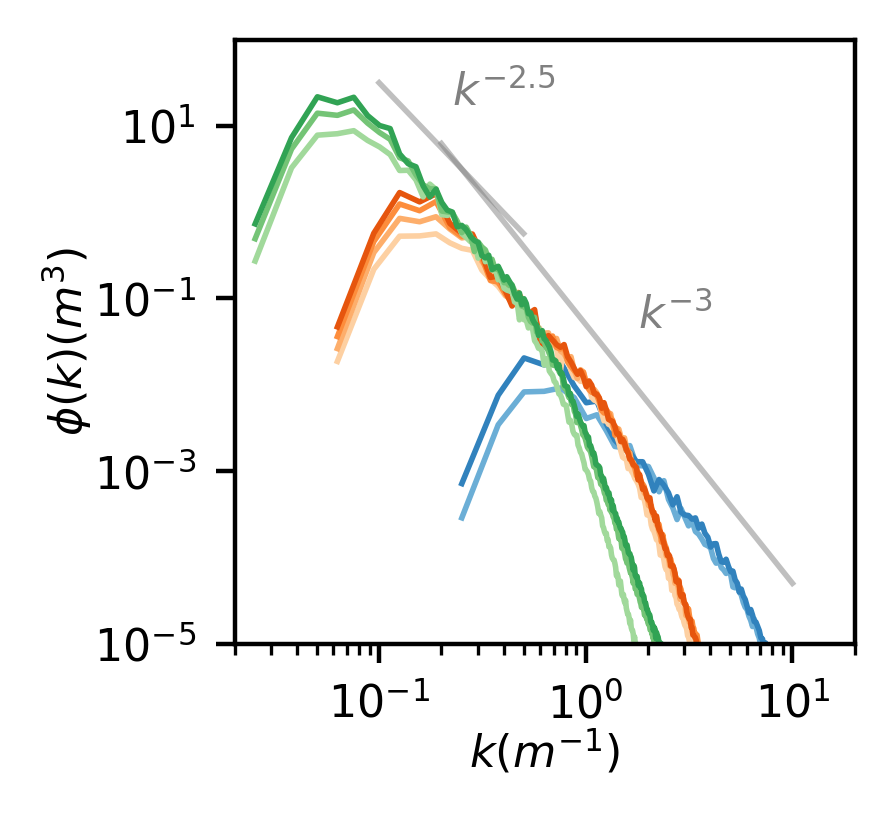

In [120]:
""" Figure: Spectrum """
fig = plt.figure(figsize=[2,2]); ax = plt.gca()
for config in (config1_1,config1_2,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3):
    plt.plot(config.kmod[2:-20], config.Fkmod[2:-20], c=config.cc, lw=1, alpha=1)
#     k_equiv = 9.8/((9.8*config.Hskp/config.kp)**0.5*0.3)**2
#     y_ = np.linspace(10**(-6), 10**1, 100)
#     x_ = np.ones(100)*k_equiv
#     plt.plot(x_, y_, '--', c=config.cc, lw=1)

x_ = np.linspace(0.1, 0.5, 100)
y_ = x_**(-2.5)*0.1
plt.plot(x_, y_, c='gray', alpha=0.5, lw=1)
x_ = np.linspace(0.2, 10, 100)
y_ = x_**(-3)*0.05
plt.plot(x_, y_, c='gray', alpha=0.5, lw=1)

ax.annotate(r'$k^{-2.5}$', xy=(0.35, 0.95), ha='left', va='top', xycoords='axes fraction', c='gray')
ax.annotate(r'$k^{-3}$', xy=(0.65, 0.58), ha='left', va='top', xycoords='axes fraction', c='gray')

plt.xscale('log'); plt.yscale('log')
plt.xlim([2*10**-2, 20])
plt.ylim([10**-5, 10**2])
plt.xlabel(r'$k(m^{-1})$', labelpad=0); plt.ylabel(r'$\phi(k)(m^3)$', labelpad=0)
fig.savefig('figures/spectrum_unit.pdf', bbox_inches='tight', pad_inches=0.1)

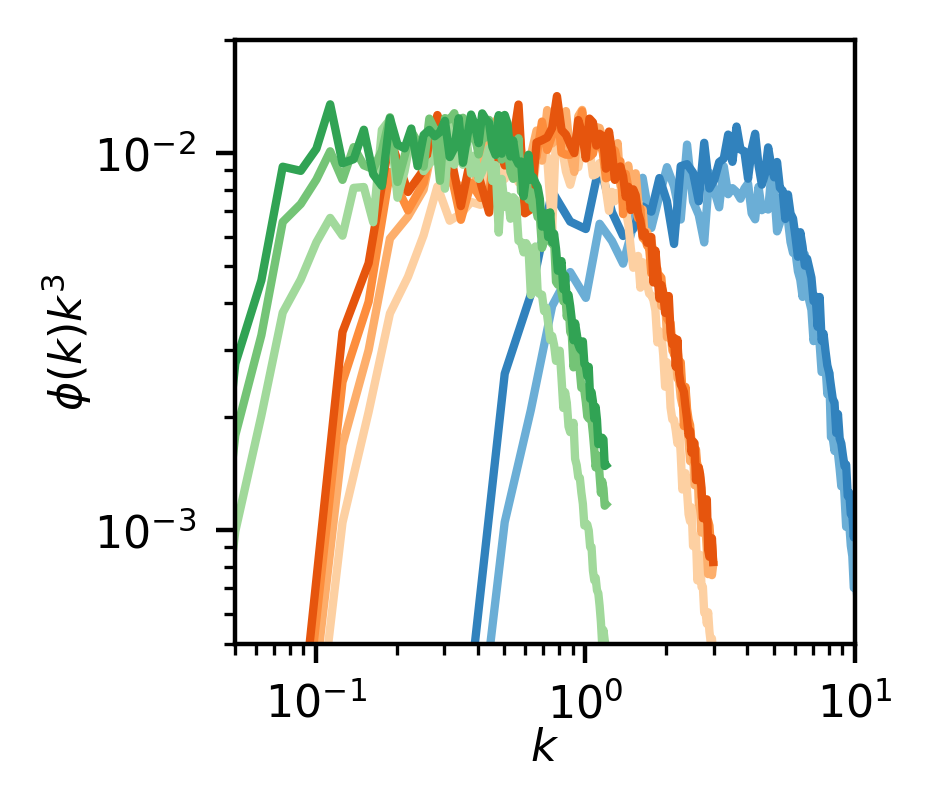

In [121]:
fig = plt.figure(figsize=[2,2])
for config in (config1_1,config1_2,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3):
    plt.plot(config.kmod[2:-160], config.Fkmod[2:-160]*(config.kmod[2:-160])**3, c=config.cc)
#     k_equiv = 9.8/(9.8*config.Hskp/config.kp)
#     y_ = np.linspace(10**(-6), 10**0, 100)
#     x_ = np.ones(100)*k_equiv
#     plt.plot(x_, y_, c='gray')
plt.xscale('log');
plt.yscale('log')
plt.xlim([5*10**-2, 10])
plt.ylim([5*10**-4, 2*10**-2])
plt.xlabel(r'$k$', labelpad=0); plt.ylabel(r'$\phi(k)k^3$', labelpad=0)
fig.savefig('figures/spectrum_saturation.pdf', bbox_inches='tight', pad_inches=0.1)

P=0.01
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.01_RE40000_9_15_rand2_Htheta0.503/
P=0.02
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.02_RE40000_9_15_rand2_Htheta0.503/
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.02_RE40000_9_15_rand2_Htheta0.503_N2/
P=0.03
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503/
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503_N2/


' Normalized '

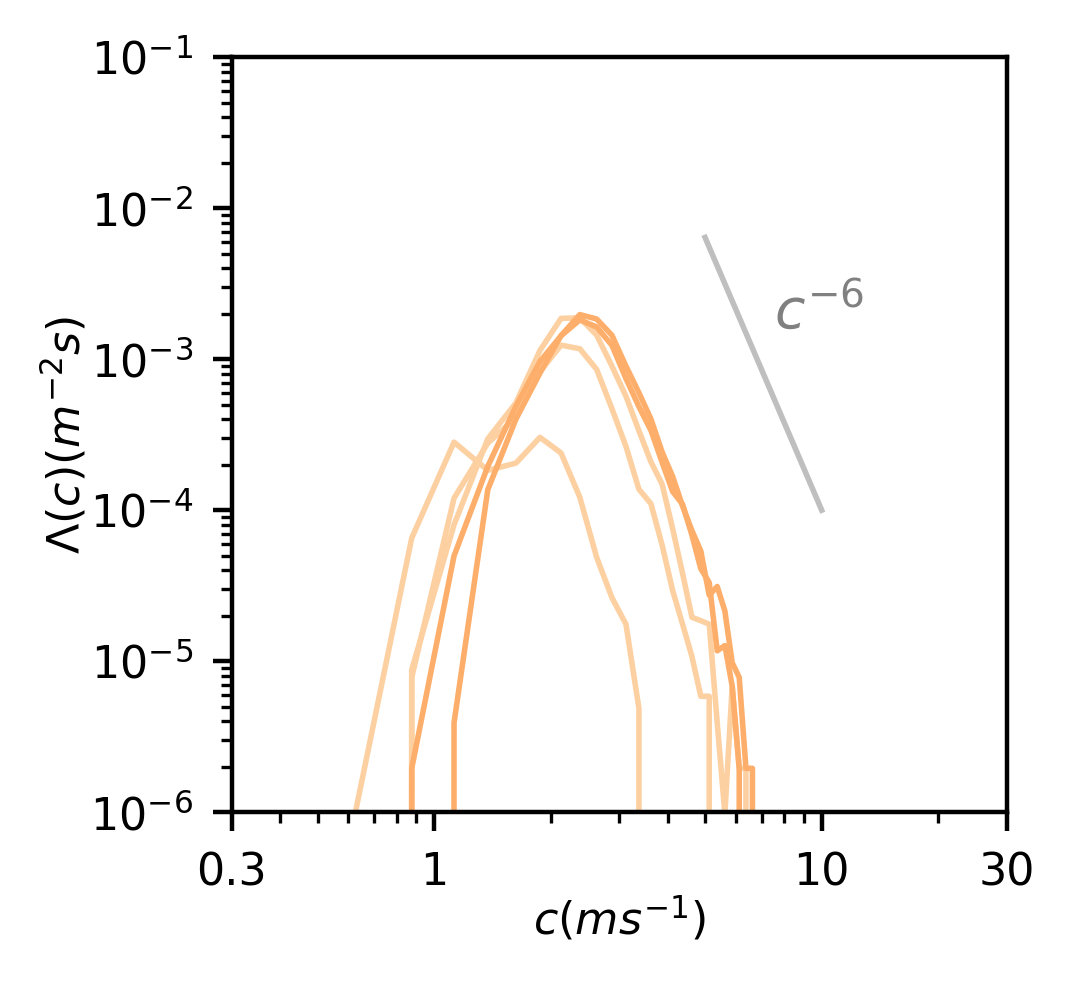

In [34]:
""" Not normalized or Normalized Lambda(x) distribution.
    hist is the number of point in each bin: normalization """
fig = plt.figure(figsize=[2.5,2.5]); ax = plt.gca()

zeroth_ensem = []
first_ensem = []

for k, config in enumerate((config2_1,config2_2,config2_3)):
    print('P=%g' %config.P)
    for j,case in enumerate(config.cases):
        normx = (9.8*config.Hskp/config.kp)**0.5
        normx = 1
        normy = config.P**(1)/(9.8*config.Hskp/config.kp)**(2)*9.8**1.5
        normy = 1
        if (case.NL == 15) and (case.LEVEL == 9) and (case.rand != 0) and (case.rand != 1) :
            print (case.path)
            bins = case.hist_ensem['bins']
            bins_plotting = bins[1:] - (bins[2] - bins[1])/2
            for i,hist in enumerate(case.hist_ensem['hist_ensem']):
                if case.Htheta == 0.51:
                    plt.plot(bins_plotting/normx, hist/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])/normy, label=config.P, c=case.config.cc, linestyle='-', alpha=1, lw=2)
                else:
                    plt.plot(bins_plotting/normx, hist/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])/normy, c=case.config.cc, alpha=1, lw=1)

                zeroth_ensem.append(np.sum(hist/2**case.LEVEL/case.config.L0))
                first_ensem.append(np.sum(hist/2**case.LEVEL/case.config.L0*bins_plotting))

plt.xscale('log'); plt.yscale('log')
from matplotlib.axis import Axis  
import matplotlib.ticker as ticker



""" Not normalized """
x_ = np.linspace(5, 10, 100)
y_ = x_**(-6)*100
plt.plot(x_, y_, c='gray', alpha=0.5, lw=1)
                
plt.xlim([0.3,30])
plt.ylim([10**(-6),10**(-1)])
plt.xticks(np.array([0.3,1,10,30]))
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
formatter = ticker.FormatStrFormatter('?%1.2f')
formatter = ticker.FormatStrFormatter('%g')
Axis.set_major_formatter(ax.xaxis, formatter)

ax.annotate(r'$c^{-6}$', xy=(0.7, 0.7), ha='left', va='top', xycoords='axes fraction', c='gray', fontsize=10)

plt.xlabel(r'$c(ms^{-1})$', labelpad=0); 
plt.ylabel(r'$\Lambda(c)(m^{-2}s)$', labelpad=0)

""" Normalized """
# x_ = np.linspace(0.6, 5, 100)
# y_ = x_**(-6)*0.2
# plt.plot(x_, y_, '--', c='gray', alpha=1, lw=1)
# x_ = np.linspace(0.5, 5, 100)
# y_ = x_**(-6)*0.02
# plt.plot(x_, y_, '--', c='gray', alpha=1, lw=1)
# ax.annotate(r'$0.2\hat{c}^{-6}$', xy=(0.55, 0.8), ha='left', va='top', xycoords='axes fraction', c='gray', fontsize=8)
# ax.annotate(r'$0.02\hat{c}^{-6}$', xy=(0.35, 0.2), ha='left', va='top', xycoords='axes fraction', c='gray', fontsize=8)

# plt.xlim([0.1,10])
# plt.ylim([10**(-4),10**(1)])
# plt.xlabel(r'$\hat{c} = c/\sqrt{gH_s}$', labelpad=0) 
# plt.ylabel(r'$\Lambda(c)P^{-1}(\sqrt{gH_s})^4g^{-3/2}$', labelpad=0)
# fig.savefig('figures/lambda_c_norm.pdf', bbox_inches='tight', pad_inches=0.1)

P=0.01
/projects/DEIKE/jiarongw/multilayer/field_new_50m_P0.01_RE40000_9_15_rand2_Htheta0.503/
P=0.02
/projects/DEIKE/jiarongw/multilayer/field_new_50m_P0.02_RE40000_9_15_rand2_Htheta0.503/
P=0.02
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.02_RE40000_9_15_rand2_Htheta0.503/
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.02_RE40000_9_15_rand2_Htheta0.503_N2/
P=0.03
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503/
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503_N2/
P=0.04
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.04_RE40000_9_15_rand2_Htheta0.503/
P=0.05
/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.05_RE40000_9_15_rand2_Htheta0.503/
P=0.03
/projects/DEIKE/jiarongw/multilayer/field_new_500m_P0.03_RE40000_9_15_rand2_Htheta0.503/
P=0.05
/projects/DEIKE/jiarongw/multilayer/field_new_500m_P0.05_RE40000_9_15_rand2_Htheta0.503/
P=0.07
/projects/DEIKE/jiarongw/multilayer/field_n

' Normalized '

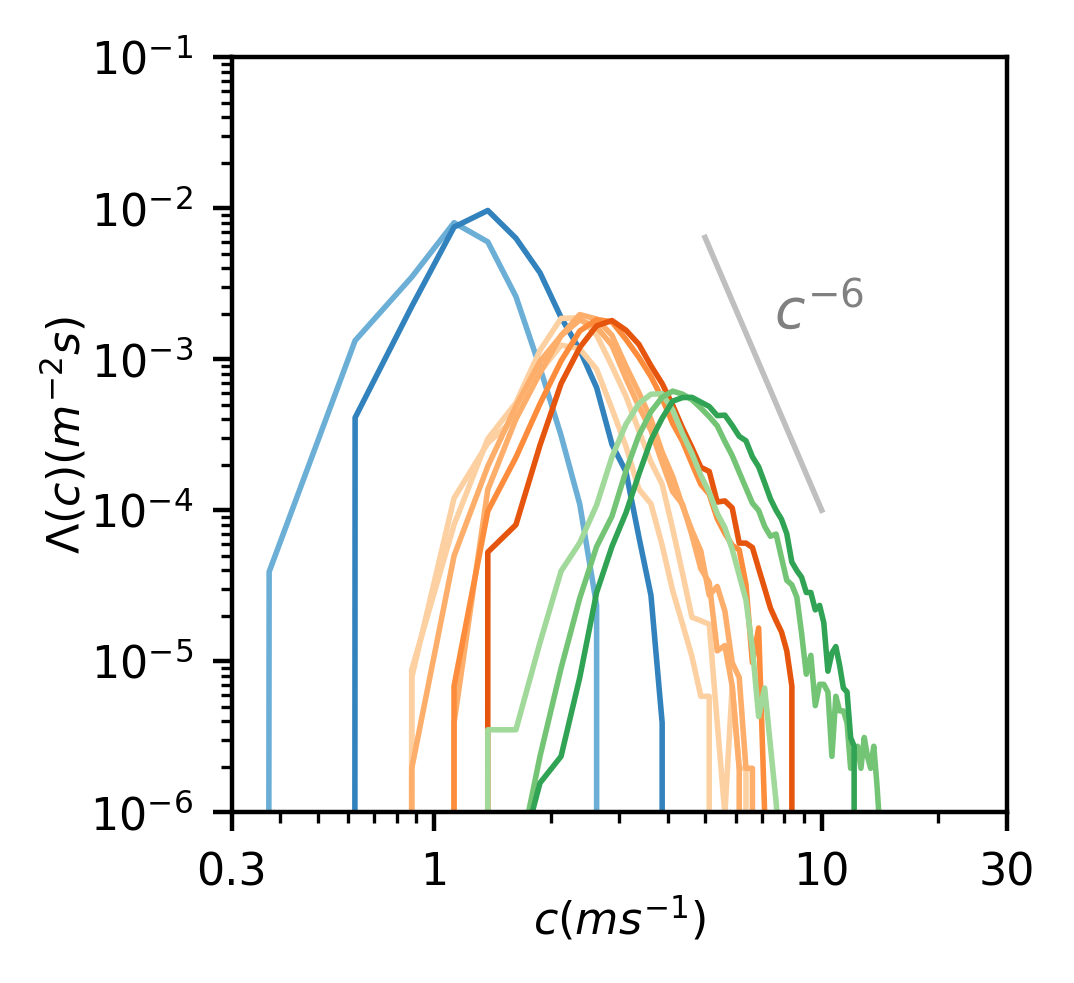

In [131]:
""" Not normalized or Normalized Lambda(x) distribution.
    hist is the number of point in each bin: normalization """
fig = plt.figure(figsize=[2.5,2.5]); ax = plt.gca()

zeroth_ensem = []
first_ensem = []

for k, config in enumerate((config1_1,config1_2,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3)):
    print('P=%g' %config.P)
    for j,case in enumerate(config.cases):
#         normx = (9.8*config.Hskp/config.kp)**0.5
        normx = 1
#         normy = config.P**(1)/(9.8*config.Hskp/config.kp)**(2)*9.8**1.5
        normy = 1
        if (case.NL == 15) and (case.LEVEL == 9) and (case.rand != 0) and (case.rand != 1):
            print (case.path)
            bins = case.hist_ensem['bins']
            bins_plotting = bins[1:] - (bins[2] - bins[1])/2
            for i,hist in enumerate(case.hist_ensem['hist_ensem']):
                if case.Htheta == 0.51:
                    plt.plot(bins_plotting/normx, hist/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])/normy, label=config.P, c=case.config.cc, linestyle='-', alpha=1, lw=2)
                else:
                    plt.plot(bins_plotting/normx, hist/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])/normy, c=case.config.cc, alpha=1, lw=1)

                zeroth_ensem.append(np.sum(hist/2**case.LEVEL/case.config.L0))
                first_ensem.append(np.sum(hist/2**case.LEVEL/case.config.L0*bins_plotting))
        """ Output csv """
        if (case.Npower==5):
            file = open("./data/Lambda(c)_kp%.3f_P%g_Hs%.3f_ustar%.3f.csv" %(config.kp, config.P, config.Hskp/config.kp, config.ustar), "w")
            fieldnames = ['c (ms-1)', 'Lambda(c) (m-2s)', 'hat{c}', 'hat{Lambda(c)}']
            writer = csv.writer(file)
            writer.writerow(fieldnames) 
            normx = (9.8*config.Hskp/config.kp)**0.5
            normy = config.P**(1)/(9.8*config.Hskp/config.kp)**(2)*9.8**1.5     
            bins_lambda_c = case.hist_ensem['hist_ensem'][0]/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])
            for c, lambda_c in zip(bins_plotting, bins_lambda_c):
                writer.writerow(['{:4f}'.format(c), '{:7f}'.format(lambda_c), '{:4f}'.format(c/normx), '{:7f}'.format(lambda_c/normy)])     
            file.close()            

plt.xscale('log'); plt.yscale('log')
from matplotlib.axis import Axis  
import matplotlib.ticker as ticker



""" Not normalized """
x_ = np.linspace(5, 10, 100)
y_ = x_**(-6)*100
plt.plot(x_, y_, c='gray', alpha=0.5, lw=1)
                
plt.xlim([0.3,30])
plt.ylim([10**(-6),10**(-1)])
plt.xticks(np.array([0.3,1,10,30]))
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
formatter = ticker.FormatStrFormatter('?%1.2f')
formatter = ticker.FormatStrFormatter('%g')
Axis.set_major_formatter(ax.xaxis, formatter)

ax.annotate(r'$c^{-6}$', xy=(0.7, 0.7), ha='left', va='top', xycoords='axes fraction', c='gray', fontsize=10)

plt.xlabel(r'$c(ms^{-1})$', labelpad=0); 
plt.ylabel(r'$\Lambda(c)(m^{-2}s)$', labelpad=0)
fig.savefig('figures/lambda_c_1.pdf', bbox_inches='tight', pad_inches=0.1)


""" Normalized """
# x_ = np.linspace(0.6, 5, 100)
# y_ = x_**(-6)*0.2
# plt.plot(x_, y_, '--', c='gray', alpha=1, lw=1)
# x_ = np.linspace(0.5, 5, 100)
# y_ = x_**(-6)*0.02
# plt.plot(x_, y_, '--', c='gray', alpha=1, lw=1)
# ax.annotate(r'$0.2\hat{c}^{-6}$', xy=(0.55, 0.8), ha='left', va='top', xycoords='axes fraction', c='gray', fontsize=8)
# ax.annotate(r'$0.02\hat{c}^{-6}$', xy=(0.35, 0.2), ha='left', va='top', xycoords='axes fraction', c='gray', fontsize=8)

# plt.xlim([0.1,10])
# plt.ylim([10**(-4),10**(1)])
# plt.xlabel(r'$\hat{c} = c/\sqrt{gH_s}$', labelpad=0) 
# plt.ylabel(r'$\Lambda(c)P^{-1}(\sqrt{gH_s})^4g^{-3/2}$', labelpad=0)
# fig.savefig('figures/lambda_c_norm.pdf', bbox_inches='tight', pad_inches=0.1)

In [ ]:
""" Fifth moment and energy """
figure = plt.figure(figsize=[3,2]); ax = plt.gca()

ensem_fifth = []
ensem_dEdt = []
for config in (config1_1,config1_2,config2_1,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3):
    for case in config.cases:
        hist_aver = np.average(np.array(case.hist_ensem['hist_ensem']), axis=0)
        bins = case.hist_ensem['bins'] 
        bins = bins[1:] - (bins[2] - bins[1])/2
        case.fifth = np.sum(bins**5*hist_aver*(bins[2] - bins[1]))
        if (case.Htheta == 0.51):
            plt.plot(case.fifth/9.8, case.dEdt, c=case.config.cc, marker='^', markersize=4)
            ensem_fifth.append(case.fifth)
            ensem_dEdt.append(case.dEdt)
        else:
            plt.plot(case.fifth/9.8, case.dEdt, c=case.config.cc, marker='^', markersize=4, markerfacecolor='None', markeredgewidth=1)
        print('L0 = %g, b = %g' %(case.config.L0, case.dEdt/(case.fifth+0.0001)*9.8))

        
from scipy.optimize import curve_fit

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

cases_200m = []
for config in [config2_1,config2_2,config2_3,config2_4,config2_5]:
    for case in config.cases:
        cases_200m.append(case)
fifth_200m = [case.fifth for case in cases_200m]
dEdt_200m = [case.dEdt for case in cases_200m]
popt, pcov = curve_fit(f, fifth_200m, dEdt_200m) # your data x, y to fit
print(popt)
x_ = np.arange(10,10**5,100)
y_ = x_*popt[0]+popt[1]
# plt.plot(x_/9.8, y_, c='gray')

# ensem_fifth = []
# ensem_dEdt = []
# for case in (config6.cases[0], config7.cases[0], config8.cases[0]):
#     hist_aver = np.average(np.array(case.hist_ensem['hist_ensem']), axis=0)
#     bins = case.hist_ensem['bins'] 
#     bins = bins[1:] - (bins[2] - bins[1])/2
#     case.fifth = np.sum(bins**5*hist_aver*(bins[2] - bins[1]))
#     plt.plot(case.fifth/9.8, case.dEdt, c=case.config.cc, marker='o', markersize=2)
#     print(case.dEdt/case.fifth)
#     ensem_fifth.append(case.fifth)
#     ensem_dEdt.append(case.dEdt)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# slope = (ensem_dEdt[-1] - ensem_dEdt[0])/(ensem_fifth[-1] - ensem_fifth[0])*9.8
# print(slope)
# intersect = - slope*ensem_fifth[0]/9.8 + ensem_dEdt[0]
# plt.plot(np.array(ensem_fifth)/9.8, slope*np.array(ensem_fifth)/9.8 + intersect, '--', color = 'gray', alpha=0.5)

ax.set_xlabel(r'$g^{-1}\int c^5\Lambda(c)dc$'); ax.set_ylabel(r'$\rho_w^{-1}dE/dt$')

# ax.text(0.8,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(45,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(800, 800,'$b=%.4f$' %slope, c='gray')
# ax.text(32000, 800,'$b=%.4f$' %slope, c='gray')
plt.xscale('log'); plt.yscale('log')
# plt.ylim([-1, 500])
# plt.xlim([0, 10000])

0.06201324890179509 0.2006906842479355
L0 = 50, b = 0.00553676
0.27100283698780153 0.3333010065899228
L0 = 50, b = 0.0017915
0.028380832334453324 0.2293608882050685
L0 = 200, b = 0.233717
0.12402649780359018 0.43560009409212197
L0 = 200, b = 0.0228689
0.12402649780359018 0.43560009409212197
L0 = 200, b = 0.040931
0.2938845355930684 0.5844130233594375
L0 = 200, b = 0.0181876
0.2938845355930684 0.5844130233594375
L0 = 200, b = 0.0253638
0.2938845355930684 0.5844130233594375
L0 = 200, b = 0.00826504
0.542005673975603 0.7259352441678526
L0 = 200, b = 0.00959195
0.8713554462179836 0.8552938468790932
L0 = 200, b = 0.00518884
0.17530984403671276 0.673406802762168
L0 = 500, b = 0.0570843
0.5197864088654615 1.000451160939539
L0 = 500, b = 0.0233593
1.063495444147414 1.2804136080229338
L0 = 500, b = 0.0193767


(0.0, 30.0)

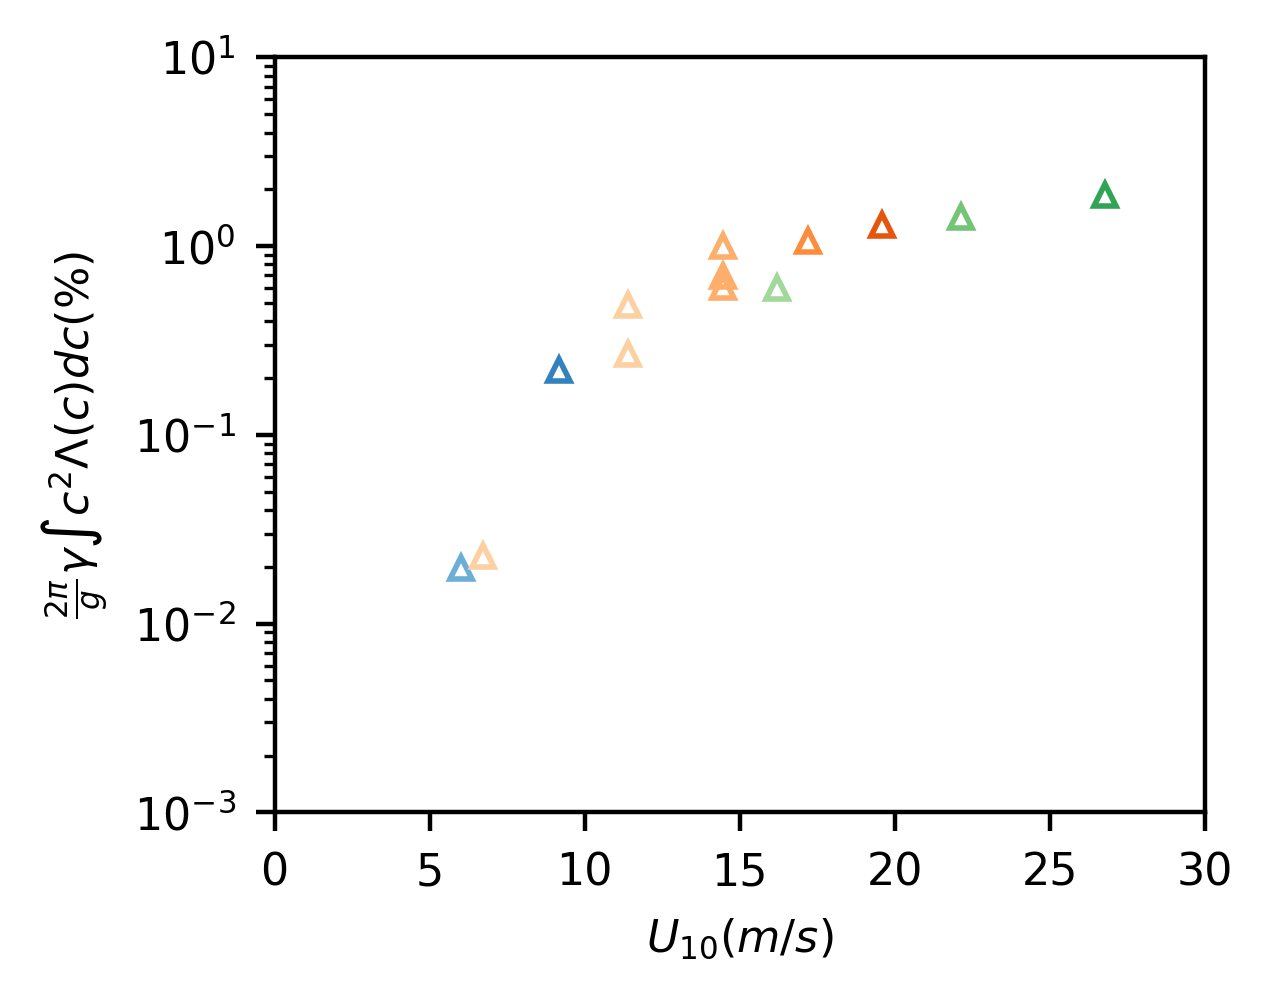

In [123]:
""" Second moment and WCC """
figure = plt.figure(figsize=[3,2.5]); ax = plt.gca()


ensem_WCC = []
ensem_U10 = []

for config in (config1_1,config1_2,config2_1,config2_2,config2_3,config2_4,config2_5,config3_1,config3_2,config3_3):
    for case in config.cases:
        hist_aver = np.average(np.array(case.hist_ensem['hist_ensem']), axis=0)
        bins = case.hist_ensem['bins'] 
        bins = bins[1:] - (bins[2] - bins[1])/2
        case.second = 0
#         case.first = 0 
#         threshold = 1*(9.8*config.Hskp/config.kp)**0.5   
        for (bin_, hist_) in zip(bins, hist_aver):
            if bin_ > 2: # the 2m/s limit
#             if bin_ > threshold: # the 2m/s limit
                case.second += bin_**2*hist_/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])
#                 case.first += bin_*hist_/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])
        case.second = case.second*(bins[2] - bins[1])

        """ Compute U10: first from fetch-limited condition get u*, and then use Charnock relation """
        const = 1
        config.cp = (9.8/config.kp)**0.5
        ustar_P = (config.P*np.exp(-1.25)/0.016/(config.cp**0.53)*9.8**0.5)**(1/0.47)
        ustar = const*((config.Hskp/config.kp*9.8)/config.cp**1.5)**2
        print(ustar_P, ustar)
        U10 = (ustar**2*np.log(10/(0.0112*ustar**2/9.8))**2/0.41**2)**0.5
#         U10 = (ustar_P**2*np.log(10/(0.0112*ustar**2/9.8))**2/0.41**2)**0.5 # More noisy!
        ensem_U10.append(U10)
        gamma = 0.56
        plt.plot(U10, case.second*2*np.pi/9.8*gamma*100, c=case.config.cc, marker='^', markersize=4, markerfacecolor='None', markeredgewidth=1)
        ensem_WCC.append(case.second*2*np.pi/9.8*gamma*100)
        config.ustar = ustar
        print('L0 = %g, b = %g' %(case.config.L0, case.dEdt/(case.fifth+0.0001)*9.8))
        
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="plain", scilimits=(0,0))

# slope = (ensem_dEdt[-1] - ensem_dEdt[0])/(ensem_fifth[-1] - ensem_fifth[0])*9.8
# print(slope)
# intersect = - slope*ensem_fifth[0]/9.8 + ensem_dEdt[0]
# plt.plot(np.array(ensem_fifth)/9.8, slope*np.array(ensem_fifth)/9.8 + intersect, '--', color = 'gray', alpha=0.5)

ax.set_ylabel(r'$\frac{2\pi}{g}\gamma\int c^2\Lambda(c)dc (\%)$'); ax.set_xlabel(r'$U_{10} (m/s)$')

# ax.text(0.8,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(45,0.15,'$b=%.4f$' %slope, c='gray')
# ax.text(800, 800,'$b=%.4f$' %slope, c='gray')
# ax.text(32000, 800,'$b=%.4f$' %slope, c='gray')
# plt.xscale('log'); 
plt.yscale('log')
plt.ylim([0.001, 10])
plt.xlim([0, 30])

In [113]:

file = open("./data/WCC.csv", "w")
fieldnames = ['U10', 'WCC']
writer = csv.writer(file)
writer.writerow(fieldnames) 
for U10, WCC in zip(ensem_U10, ensem_second):
    writer.writerow([round(U10, 3), round(WCC, 6)])     
file.close()

### The dataset shared by Luc (and wind condition)

In [ ]:
# """ Compute ustar """
# config = config7
# config.cp = (9.8/config.kp)**0.5
# config.ustar = ((config.Hskp0/config.kp*9.8)**0.5/config.cp**0.75)**4
# print(config.ustar)

In [ ]:
""" wavenumer to frequency g = 9.8 """
g = 9.8
k = 0.1
omega = (g*k)**0.5
print(omega)
print(omega/2/np.pi)

""" freq to k """
f = 0.2 
omega = 2*np.pi*f
k = omega**2/g
print(k)

In [ ]:
r09 = pd.read_csv('/projects/DEIKE/jiarongw/multilayer/metadata_r09.csv', names=['cp','kp','Hs','ustar','U10','rho_a'])  
s10 = pd.read_csv('/projects/DEIKE/jiarongw/multilayer/metadata_s10.csv', names=['cp','kp','Hs','ustar','U10','rho_a'])  

In [67]:
const = (2*np.pi)**(1.5)*0.062
i = 0
S = r09.cp[i]*r09.Hs[i]
kp = r09.kp[i]
cp = (9.8/kp)**0.5
print(cp)
print(r09.cp[i])
ustar = (S/const/9.8**(3/2))**2*r09.cp[i]
print(ustar)
print(r09.ustar[i])

2.9640003496310823
8.7941
2.3094693985789814
0.26637


In [69]:
const = (2*np.pi)**(1.5)*0.062
i = 0
kp = r09.kp[i]
cp = (9.8/kp)**0.5
S = cp*r09.Hs[i]
print(cp)
print(r09.cp[i])
ustar = (S/const/9.8**(3/2))**2*cp
print(ustar)
print(r09.ustar[i])

2.9640003496310823
8.7941
0.08842453085209462
0.26637


In [64]:
const = (2*np.pi)**(1.5)*0.062
i = 0
S = s10.cp[i]*s10.Hs[i]
kp = s10.kp[i]
cp = (9.8/kp)**0.5
print(cp)
print(s10.cp[i])
ustar = (S/const/9.8**(3/2))**2*cp
print(ustar)

2.7543263551814046
7.5938
0.18330404354676375


In [ ]:
b1 = (1.0651/50**2)*9.8/S_diss1/(2*np.pi)
print(b1)
b2 = (1.39/50**2)*9.8/S_diss2/(2*np.pi)
print(b2)

In [ ]:
""" From fetch-limited condition, get u* """
const = (2*np.pi)**(1.5)*0.062
S = 0.4
kp = 2*np.pi/500*5
cp = (9.8/kp)**0.5
print(cp)
ustar = (S/const/9.8**(3/2))**2*cp
print(ustar)

In [ ]:
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_500m_P08_RE40000_9_30_rand0_noHtheta/surface/'
filename = filepath + 'uy_matrix_%g' %80
plt.figure(figsize=[4,3]); ax = plt.gca()
uy = np.fromfile(filename, dtype=np.float32)
uy = uy.reshape(N+1,N+1); uy = uy[1:,1:]
uy = np.rot90(uy)
image = ax.imshow(uy, extent=[-L/2,L/2,-L/2,L/2], cmap='viridis', vmax=4, vmin=-4)
print(uy[425,200])
cbar = plt.colorbar(image)
cbar.set_label(r'$u_y$')
ax.axis('off')

In [ ]:
filename = filepath + 'ux_matrix_%g' %80
plt.figure(figsize=[4,3]); ax = plt.gca()
ux = np.fromfile(filename, dtype=np.float32)
ux = ux.reshape(N+1,N+1); ux = ux[1:,1:]
ux = np.rot90(ux)
image = ax.imshow(ux, extent=[-L/2,L/2,-L/2,L/2], cmap='viridis')
print(ux[425,200])
cbar = plt.colorbar(image)
cbar.set_label(r'$u_x$')
ax.axis('off')

In [ ]:
n,bins,_ = plt.hist(ux.flatten(), bins=40, density=True, alpha=0.5)
print(ux.mean())

### Extra validation (Lambda c)

In [ ]:
""" CHECKS: check that the spectrum looks the same for two different box sizes """

plt.figure(figsize=[2,2])
case = config2_3.cases[0]
for t in (0, 40, 80):
    eta = case.read_t(fieldname='eta', t=t)  
    kmod, Fkmod = spectrum_integration(eta, CHECK=False, L=case.config.L0, N=2**case.LEVEL)
    plt.plot(kmod, Fkmod, c=plt.cm.get_cmap('Greens')(1-t/120))

case = config2_6.cases[0]
for t in (0, 40, 80):
    eta = case.read_t(fieldname='eta', t=t)  
    kmod, Fkmod = spectrum_integration(eta[0:512,0:512], CHECK=False, L=250, N=2**9)
    plt.plot(kmod, Fkmod, '--', c=plt.cm.get_cmap('Greens')(1-t/120))

# case = config2_7.cases[0]
# t = 0
# eta = case.read_t(fieldname='eta', t=t)  
# kmod, Fkmod = spectrum_integration(eta[0:512,0:512], CHECK=False, L=200, N=2**9)
# print(kmod[0])
# plt.plot(kmod, Fkmod, '.')
# print(np.var(eta)*4*case.config.kp)
plt.xscale('log'); plt.yscale('log')
plt.ylim([10**-3, 10**1])
plt.xlabel('$k$'); plt.ylabel(r'$\phi(k)$')

In [ ]:
""" Compute the breaking stats (validation case for different box size) """
for k, config in enumerate((config2_3,config2_6)):
    for case in config.cases:
        print (case.path)
        energy = read(case.path, 'energy_after_remap.dat')
        case.dEdt = (energy[energy.t==70]['ke'].values[0] - energy[energy.t==90]['ke'].values[0] + energy[energy.t==70]['gpe'].values[0] - energy[energy.t==90]['gpe'].values[0])/20
        print(case.dEdt)
        case.time_window(tseries_ensem3, threshold=0, bins=[])

In [ ]:
""" CHECKS: check that the Lambda(c) looks the same for two different box sizes """
plt.figure(figsize=[2,2])

zeroth_ensem = []
first_ensem = []

config2_3.cc = plt.cm.get_cmap('tab20c')(0)
config2_6.cc = plt.cm.get_cmap('tab20c')(4)
for k, config in enumerate((config2_3, config2_6)):
    ensem = []
    for j,case in enumerate(config.cases):
#         norm = (9.8*config.Hskp/config.kp)**0.5
#         norm = (9.8/config.kp)**0.5
        norm = 1
#         normy = 1/(config.Hskp/config.kp)**1
        normy = config.P**(5/3)
#         normy = 1
        print(normy)
        if (case.NL == 15) and (case.rand != 0) and (case.rand != 1) and (case.Npower==5):
            print (case.path)
            bins = case.hist_ensem['bins']
            bins_plotting = bins[1:] - (bins[2] - bins[1])/2
            for i,hist in enumerate(case.hist_ensem['hist_ensem']):
                if case.Htheta == 0.51:
                    plt.plot(bins_plotting/norm, hist/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])/normy, '.', label=config.P, c=case.config.cc, linestyle='-', alpha=1, lw=2)
                else:
                    plt.plot(bins_plotting/norm, hist/2**case.LEVEL/case.config.L0/(bins[2] - bins[1])/normy, '.', c=case.config.cc, alpha=0.6, lw=1)
                ensem.append(hist/2**case.LEVEL)
                zeroth_ensem.append(np.sum(hist/2**case.LEVEL/case.config.L0))
                first_ensem.append(np.sum(hist/2**case.LEVEL/case.config.L0*bins_plotting))
    ensem = np.array(ensem)
    print(ensem.shape)
#     plt.plot(bins_plotting, np.average(ensem, axis=0), label='$L_0$ = %g, ' %(config.L0) + config.P, c=plt.cm.get_cmap('tab20c')(k*4), lw=2)

                
# plt.xlim([0.02,2])
# plt.ylim([10**(-6),10**(-1)])
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$c$'); plt.ylabel(r'$\Lambda(c)$')
# plt.legend(loc='upper left', fontsize=6)

In [ ]:
""" Horizontal convergence """
config4.cases[0].time_window(tseries_ensem2, threshold=0, bins=[])
config4.cases[-1].time_window(tseries_ensem2, threshold=-0.029, bins=[])

for j,case in enumerate((config4.cases[0],config4.cases[-1])):
    bins = case.hist_ensem['bins']
    bins_plotting = bins[1:] - (bins[2] - bins[1])/2

    for i,hist in enumerate(case.hist_ensem['hist_ensem']):
        plt.plot(bins_plotting, hist/2**case.LEVEL, label='LEVEL=%g, t_window%g' %(case.LEVEL,i), c=plt.cm.get_cmap('tab20c')(j*4+i)) # divided by N=2**case.LEVEL to get the area normalization

plt.xlim([0.1,15]); plt.ylim([10**(-5),10**(1)])
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$c$'); plt.ylabel(r'$\Lambda(c)$')
plt.legend(loc='upper left', fontsize=6)

kp = 2*np.pi/500*5; cp = (9.8/kp)**0.5
plt.plot(np.ones(10)*cp, np.linspace(1e-4, 1e-2, 10), '--', lw=1, c='gray')
kp = 2*np.pi/50*5; cp = (9.8/kp)**0.5
plt.plot(np.ones(10)*cp, np.linspace(1e-4, 1e-2, 10), '--', lw=1, c='gray')  

In [ ]:
""" Layer number convergence """
for case in config1.cases[0:3]:
    case.time_window(tseries_ensem1, threshold=0, bins=[])

for j,case in enumerate(config1.cases[0:3]):
    bins = case.hist_ensem['bins']
    bins_plotting = bins[1:] - (bins[2] - bins[1])/2

    for i,hist in enumerate(case.hist_ensem['hist_ensem']):
        plt.plot(bins_plotting, hist/2**case.LEVEL, label='NL=%g' %(case.NL), c=plt.cm.get_cmap('tab20c')(j)) # divided by N=2**case.LEVEL to get the area normalization

plt.xlim([0.1,15]); plt.ylim([10**(-5),10**(1)])
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$c$'); plt.ylabel(r'$\Lambda(c)$')
plt.legend(loc='upper left')

kp = 2*np.pi/500*5; cp = (9.8/kp)**0.5
plt.plot(np.ones(10)*cp, np.linspace(1e-4, 1e-2, 10), '--', lw=1, c='gray')
kp = 2*np.pi/50*5; cp = (9.8/kp)**0.5
plt.plot(np.ones(10)*cp, np.linspace(1e-4, 1e-2, 10), '--', lw=1, c='gray')  

In [ ]:
""" Sensitiveness to detection method """
case = config2.cases[0]
ensem_main = []
for j,thres in enumerate((-0.007,-0.006,-0.005)):
    print(j)
    case.time_window(tseries_ensem2, method=0, threshold=thres, bins=[])
    ensem = []
    bins = case.hist_ensem['bins']
    bins_plotting = bins[1:] - (bins[2] - bins[1])/2
    for i,hist in enumerate(case.hist_ensem['hist_ensem']):
        plt.plot(bins_plotting, hist/2**case.LEVEL/normy, c=plt.cm.get_cmap('tab20c')(j), alpha=0.3, lw=1) # divided by N=2**case.LEVEL to get the area normalization
        ensem.append(hist/2**case.LEVEL)
    ensem = np.array(ensem)
    plt.plot(bins_plotting, np.average(ensem, axis=0)/normy, label='Ridge, thres=%g' %thres, c=plt.cm.get_cmap('tab20c')(j), lw=2)
    ensem_main.append(np.average(ensem, axis=0))
for j,thres in enumerate((-0.3,-0.4,-0.5)):
    print(j)
    case.time_window(tseries_ensem2, method=1, threshold=thres, bins=[])
    ensem = []
    bins = case.hist_ensem['bins']
    bins_plotting = bins[1:] - (bins[2] - bins[1])/2
    for i,hist in enumerate(case.hist_ensem['hist_ensem']):
        plt.plot(bins_plotting, hist/2**case.LEVEL/normy, c=plt.cm.get_cmap('tab20c')(4+j), alpha=0.3, lw=1) # divided by N=2**case.LEVEL to get the area normalization
        ensem.append(hist/2**case.LEVEL)
    ensem = np.array(ensem)
    plt.plot(bins_plotting, np.average(ensem, axis=0)/normy, label='Slope, thres=%g' %thres, c=plt.cm.get_cmap('tab20c')(4+j), lw=2)
    ensem_main.append(np.average(ensem, axis=0))

plt.xlim([0.08,10])
plt.ylim([10**(-5),10**(1)])
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$c$'); plt.ylabel(r'$\Lambda(c)$')
plt.legend(loc='upper right', fontsize=6)

In [ ]:
for k, config in enumerate((config2,config3,config4,config5,config6)):
    ensem = []
    print('$\sqrt{gH_s} = %g, c_p = %g$' %((9.8*config.Hskp0/config.kp)**0.5, (9.8/config.kp)**0.5))
    norm = (9.8*config.Hskp0/config.kp)**0.5 # X axis normalization 1
#     norm = (9.8/config.kp)**0.5 # X axis normalization 2
#     gHs = 9.8*config.Hskp0/config.kp
#     normy = gHs**1.5/9.8*(config.ustar/gHs**0.5)**(5/3)
#     normy = (config.Fkmod.max()*config.kp**3)**0.5
    normy = 1
    print(config.Fkmod.max())
#     norm = 1
    for j,case in enumerate(config.cases):
        if (case.NL == 15) and (case.LEVEL == 9) and (case.rand != 0) and (case.rand != 1):
            print (case.path)
            bins = case.hist_ensem['bins']
            bins_plotting = bins[1:] - (bins[2] - bins[1])/2
            for i,hist in enumerate(case.hist_ensem['hist_ensem']):
                plt.plot(bins_plotting/norm, hist/2**case.LEVEL/normy, c=plt.cm.get_cmap('tab20c')(k*4), alpha=0.3, lw=1) # divided by N=2**case.LEVEL to get the area normalization
                ensem.append(hist/2**case.LEVEL)
    ensem = np.array(ensem)
    print(ensem.shape)
    plt.plot(bins_plotting/norm, np.average(ensem, axis=0)/normy, label='$L_0$ = %g, ' %(config.L0) + config.P, c=plt.cm.get_cmap('tab20c')(k*4), lw=2)
                
plt.xlim([0.05,4])
plt.ylim([10**(-5),10**(1)])
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$c/\sqrt{gH_s}$'); plt.ylabel(r'$\Lambda(c)\sqrt{gH_s}^3g^{-1}(u_*/\sqrt{gH_s})^{5/3}$')
plt.legend(loc='upper left', fontsize=6)

# kp = 2*np.pi/500*5; cp = (9.8/kp)**0.5
# plt.plot(np.ones(10)*cp, np.linspace(1e-4, 1e-2, 10), '--', lw=1, c='gray')
# kp = 2*np.pi/50*5; cp = (9.8/kp)**0.5
# plt.plot(np.ones(10)*cp, np.linspace(1e-4, 1e-2, 10), '--', lw=1, c='gray')  

### Extra validation (energy)

In [ ]:
""" If the theta_H parameter change anything"""

for k, config in enumerate((config1,config2,config3,config4,config5)):
    ensem = []
    for j,case in enumerate(config.cases):
        if (case.NL == 15) and (case.LEVEL == 9) and (case.rand != 0) and (case.rand != 1):
            print (case.path)
            bins = case.hist_ensem['bins']
            bins_plotting = bins[1:] - (bins[2] - bins[1])/2
            for i,hist in enumerate(case.hist_ensem['hist_ensem']):
                if case.Htheta == 0.51:
                    plt.plot(bins_plotting, hist/2**case.LEVEL, label=config.P, c=plt.cm.get_cmap('tab20c')(k*4+j), linestyle='-', alpha=1, lw=2)
                else:
                    plt.plot(bins_plotting, hist/2**case.LEVEL, c=plt.cm.get_cmap('tab20c')(k*4+j), linestyle='--', alpha=0.6, lw=1)
                ensem.append(hist/2**case.LEVEL)
    ensem = np.array(ensem)
    print(ensem.shape)
#     plt.plot(bins_plotting, np.average(ensem, axis=0), label='$L_0$ = %g, ' %(config.L0) + config.P, c=plt.cm.get_cmap('tab20c')(k*4), lw=2)

for k, config in enumerate((config6,config7,config8,config9)):
    ensem = []
    for j,case in enumerate(config.cases):
        if (case.NL == 15) and (case.LEVEL == 9) and (case.rand != 0) and (case.rand != 1):
            print (case.path)
            bins = case.hist_ensem['bins']
            bins_plotting = bins[1:] - (bins[2] - bins[1])/2
            for i,hist in enumerate(case.hist_ensem['hist_ensem']):
                if case.Htheta == 0.51:
                    plt.plot(bins_plotting, hist/2**case.LEVEL, label=config.P, c=plt.cm.get_cmap('tab20b')(k*4+j), linestyle='-', alpha=1, lw=2)
                else:
                    plt.plot(bins_plotting, hist/2**case.LEVEL, c=plt.cm.get_cmap('tab20b')(k*4+j), linestyle='--', alpha=0.6, lw=1)
                ensem.append(hist/2**case.LEVEL)
    ensem = np.array(ensem)
    print(ensem.shape)
                
plt.xlim([0.1,14])
plt.ylim([10**(-5),10**(1)])
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$c$'); plt.ylabel(r'$\Lambda(c)$')
plt.legend(loc='upper left', fontsize=6)

In [ ]:
fig = plt.figure(figsize=[4,3]); ax = fig.gca()

""" theta_H validation """

case = config1.cases[0]
energy = read(case.path, 'energy_after_remap.dat')
l1 = plot(ax, energy, label=r'RE=%g, $\theta_H=%g$' %(case.RE,case.Htheta), color=plt.cm.get_cmap('tab20c')(0))
case = config1.cases[1]
energy = read(case.path, 'energy_after_remap.dat')
l1 = plot(ax, energy, label=r'RE=%g, $\theta_H=%g$' %(case.RE,case.Htheta), color=plt.cm.get_cmap('tab20c')(1))

case = config2.cases[0]
energy = read(case.path, 'energy_after_remap.dat')
l1 = plot(ax, energy, label=r'RE=%g, $\theta_H=%g$' %(case.RE,case.Htheta), color=plt.cm.get_cmap('tab20c')(4))
case = config2.cases[1]
energy = read(case.path, 'energy_after_remap.dat')
l1 = plot(ax, energy, label=r'RE=%g, $\theta_H=%g$' %(case.RE,case.Htheta), color=plt.cm.get_cmap('tab20c')(5))
case = config2.cases[2]
energy = read(case.path, 'energy_after_remap.dat')
l1 = plot(ax, energy, label=r'RE=%g, $\theta_H=%g$' %(case.RE,case.Htheta), color=plt.cm.get_cmap('tab20c')(6))

case = config3.cases[0]
energy = read(case.path, 'energy_after_remap.dat')
l1 = plot(ax, energy, label=r'RE=%g, $\theta_H=%g$' %(case.RE,case.Htheta), color=plt.cm.get_cmap('tab20c')(8))
case = config3.cases[1]
energy = read(case.path, 'energy_after_remap.dat')
l1 = plot(ax, energy, label=r'RE=%g, $\theta_H=%g$' %(case.RE,case.Htheta), color=plt.cm.get_cmap('tab20c')(9))


plt.legend(bbox_to_anchor=(1.1, 1.2))
ax.set_xlabel(r'$t$');ax.set_ylabel(r'$E$')
# plt.ylim([0,1e6])
# plt.xlim([60,100])

In [ ]:
fig = plt.figure(figsize=[3,2]); ax = fig.gca()
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

""" 500m """
case = config2_0.cases[0]
energy = read(case.path, 'energy_after_remap.dat')
l4 = plot(ax, energy, label='P=%g' %case.config.P, color=plt.cm.get_cmap('tab20c')(4))
case = config2_1.cases[0]
energy = read(case.path, 'energy_after_remap.dat')
l4 = plot(ax, energy, label='P=%g' %case.config.P, color=plt.cm.get_cmap('tab20c')(5))
case = config2_2.cases[0]
energy = read(case.path, 'energy_after_remap.dat')
l4 = plot(ax, energy, label='P=%g' %case.config.P, color=plt.cm.get_cmap('tab20c')(6))

plt.legend(loc='upper right')
plt.xlabel(r'$t$');plt.ylabel(r'$E$')
plt.xlim([0,120])
plt.ylim([-1e4,4e4])


In [ ]:
fig = plt.figure(figsize=[4,3]); ax = fig.gca()

""" 50m, layer number convergence """

case = config2_3.cases[0]
energy = read(case.path, 'energy_after_remap.dat')
l5 = plot(ax, energy, label=r'$NL=%g$' %case.NL, color=plt.cm.get_cmap('tab20c')(0))
case = config2_3.cases[2]
energy = read(case.path, 'energy_after_remap.dat')
l5 = plot(ax, energy, label=r'$NL=%g$' %case.NL, color=plt.cm.get_cmap('tab20c')(1))
case = config2_3.cases[3]
energy = read(case.path, 'energy_after_remap.dat')
l5 = plot(ax, energy, label=r'$NL=%g$' %case.NL, color=plt.cm.get_cmap('tab20c')(2))

plt.legend(loc='lower left')
plt.xlabel(r'$t$');plt.ylabel(r'$E$')
plt.xlim([0,120])

### Old code

In [ ]:
# Processing routine
from skimage.filters import meijering, threshold_isodata
from skimage.morphology import dilation, closing, disk, rectangle
from skimage.measure import label, regionprops

def process_field(raw_figure, hard_thres=False):
    # sigmas=range(1, 10, 2), alpha 
    ridge = meijering(raw_figure, sigmas=1, black_ridges=True)
    dilated = dilation(ridge, rectangle(10,2))
    closed = closing(ridge, rectangle(10,2))
    # Have the option of choosing dilated or ridge detected
    thresh = threshold_isodata(ridge)
    binary = ridge > thresh
    binary_label = label(binary, connectivity=2)
    return ridge, dilated, closing, binary, binary_label

def process_field_hardthres(raw_figure):
    hard = hard_threshold(raw_figure, 0.3)
    binary = hard < 0 
    binary_label = label(binary, connectivity=2)
    return binary, binary_label

def prop_select(binary_label, length_threshold=40):
    region_props = regionprops(binary_label)
    selected = []
    for (i,prop) in enumerate(region_props):
        if prop.perimeter > length_threshold:
            selected.append(prop)
    return selected
            
def visual_process(ridge, dilated, closing, binary, binary_label, selected):
    global pixel_size
    fig, axes = plt.subplots(1, 5, figsize=(30,10))
    for i in range(0,5):
        axes[i].set_axis_off()
    axes[0].imshow(eta_gradx, cmap = 'gray', vmax=0.577, vmin=-0.577); axes[0].set_title('Orginal Slope')
    axes[1].imshow(ridge, cmap = 'gray'); axes[1].set_title('Ridge Detection')
    axes[2].imshow(binary, cmap = 'gray'); axes[2].set_title('Dilation & Threshold Filter')
    axes[3].imshow(binary_label); axes[3].set_title('Label & Properties Extraction')
    axes[4].imshow(eta_gradx, vmax=0.577, vmin=-0.577); axes[4].set_title('Centroid on Original Plot')
    for (i,prop) in enumerate(selected):
        axes[3].plot(prop.centroid[1], prop.centroid[0], '.', color='r')
        axes[3].annotate('%g (%.1f, %.1f)' %(i, prop.centroid[1]*pixel_size, prop.centroid[0]*pixel_size), xy=(prop.centroid[1], prop.centroid[0]), 
                         xytext=(prop.centroid[1], prop.centroid[0]),
                         arrowprops=dict(arrowstyle='-'), color='w')
        axes[4].plot(prop.centroid[1], prop.centroid[0], '.', color='r', alpha = 0.5)
    plt.tight_layout()

# Example
pixel_size = 50/512
# ridge, dilated, closing, binary, binary_label = process_field(eta_gradx, hard_thres=True)
visual_process(ridge, dilated, closing, binary, binary_label, selected)   
binary, binary_labeled = process_field_hardthres(eta_gradx)
selected = prop_select(binary_label, length_threshold=60)